<a href="https://colab.research.google.com/github/danieleinar/Mynstursgreining---Lokaverkefni/blob/main/mynstur_lokaverkefni_tensorflow_fleiri_gogn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.6 MB/s eta 0:00:00


In [2]:
import chess
import chess.syzygy
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/My Drive/Colab Notebooks'

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks


In [4]:
tablebase = chess.syzygy.Tablebase()
tablebase.add_directory('Tablebase')

6

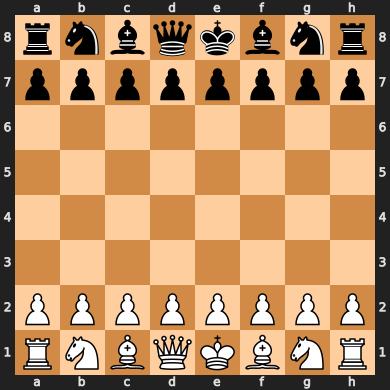

In [5]:
board = chess.Board()
board

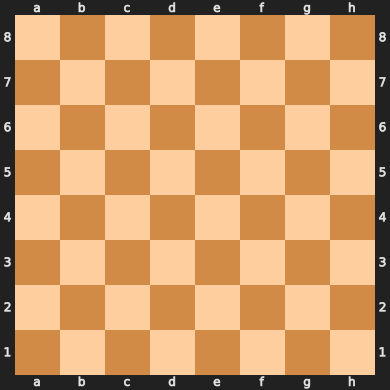

In [6]:
board.clear()
board

Ég bý til 100 þúsund gagnapunkta. Til þess þurfti 141200 tilraunir því 41200 stöður voru ólöglegar. Hvítur getur unnið í 65584 skipti af þessum 100 þúsund stöðum.

In [7]:
N = 100000
innmerki = np.zeros((N, 8), dtype=int)
sigur = np.zeros(N, dtype=int)
einkunn = np.zeros(N)

n = 0
teljari = 0
np.random.seed(37)

while n < N:
  reitir = np.random.choice(64, size=4, replace=False)
  teljari += 1
  board.clear()
  board.set_piece_at(reitir[0], chess.Piece(6, 1))  # Hvítur kóngur
  board.set_piece_at(reitir[1], chess.Piece(5, 1))  # Hvít drottning
  board.set_piece_at(reitir[2], chess.Piece(6, 0))  # Svartur kóngur
  board.set_piece_at(reitir[3], chess.Piece(4, 0))  # Svartur hrókur
  board.push(chess.Move.null())                     # Svartur á að leika
  if board.is_valid() and not board.is_checkmate():
    innmerki[n, 0] = chess.square_file(reitir[0])
    innmerki[n, 1] = chess.square_rank(reitir[0])
    innmerki[n, 2] = chess.square_file(reitir[1])
    innmerki[n, 3] = chess.square_rank(reitir[1])
    innmerki[n, 4] = chess.square_file(reitir[2])
    innmerki[n, 5] = chess.square_rank(reitir[2])
    innmerki[n, 6] = chess.square_file(reitir[3])
    innmerki[n, 7] = chess.square_rank(reitir[3])
    dtz = tablebase.probe_dtz(board)
    sigur[n] = (dtz < 0) * 1
    einkunn[n] = dtz / (-2.)
    n += 1

print(teljari)
print(np.sum(sigur))

141200
65584


Sömu pælingar og áður.

In [8]:
fjoldi_sigra = np.sum(sigur)
innmerki_w = np.zeros((fjoldi_sigra, 8), dtype=int)
einkunn_w = np.zeros(fjoldi_sigra)

stak = 0

for n in range(N):
  if sigur[n] == 1:
    innmerki_w[stak] = innmerki[n]
    einkunn_w[stak] = einkunn[n]
    stak += 1

Tíðni hverrar einkunnar:

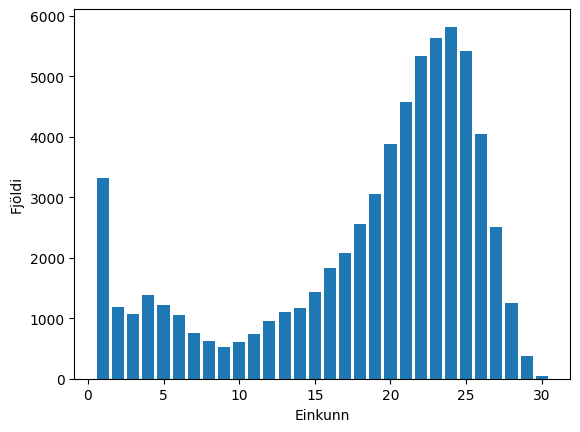

In [9]:
import matplotlib.pyplot as plt
plt.bar(*np.unique(einkunn_w, return_counts=True))
plt.xlabel('Einkunn')
plt.ylabel('Fjöldi')
plt.show()

In [10]:
from sklearn.model_selection import train_test_split

80% gagnanna verða notuð fyrir þjálfun og 20% fyrir validation.

In [11]:
inn_tr, inn_val, sigur_tr, sigur_val = train_test_split(innmerki, sigur, test_size=0.2, random_state=37)
inn_w_tr, inn_w_val, eink_w_tr, eink_w_val = train_test_split(innmerki_w, einkunn_w, test_size=0.2, random_state=37)

In [12]:
print(inn_tr.shape)
print(inn_val.shape)
print(sigur_tr.shape)
print(sigur_val.shape)
print(inn_w_tr.shape)
print(inn_w_val.shape)
print(eink_w_tr.shape)
print(eink_w_val.shape)

(80000, 8)
(20000, 8)
(80000,)
(20000,)
(52467, 8)
(13117, 8)
(52467,)
(13117,)


Skala innmerkin.

In [13]:
inn_tr_skalad = inn_tr / 3.5 - 1.0
inn_val_skalad = inn_val / 3.5 - 1.0
inn_w_tr_skalad = inn_w_tr / 3.5 - 1.0
inn_w_val_skalad = inn_w_val / 3.5 - 1.0

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras

In [15]:
tf.__version__

'2.15.0'

Djúpt tauganet með 2 földum lögum - flokkun

In [ ]:
flokkun_1 = keras.models.Sequential()
flokkun_1.add(keras.layers.Dense(64, activation="relu"))
flokkun_1.add(keras.layers.Dense(64, activation="relu"))
flokkun_1.add(keras.layers.Dense(1, activation="sigmoid"))

In [ ]:
flokkun_1.build((None,8))

In [ ]:
flokkun_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                576       
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4801 (18.75 KB)
Trainable params: 4801 (18.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
flokkun_1.layers

In [ ]:
flokkun_1.compile(loss="binary_crossentropy",
              optimizer='adam',
              metrics=["accuracy"])

In [ ]:
history_fl_1 = flokkun_1.fit(inn_tr_skalad, sigur_tr, epochs=20,
                    validation_data=(inn_val_skalad, sigur_val))

Epoch 1/20
2500/2500 [==============================] - 10s 3ms/step - loss: 0.5667 - accuracy: 0.7092 - val_loss: 0.4831 - val_accuracy: 0.7885
Epoch 2/20
2500/2500 [==============================] - 8s 3ms/step - loss: 0.3458 - accuracy: 0.8811 - val_loss: 0.2607 - val_accuracy: 0.9212
Epoch 3/20
2500/2500 [==============================] - 8s 3ms/step - loss: 0.2284 - accuracy: 0.9309 - val_loss: 0.2057 - val_accuracy: 0.9385
Epoch 4/20
2500/2500 [==============================] - 8s 3ms/step - loss: 0.1838 - accuracy: 0.9445 - val_loss: 0.1694 - val_accuracy: 0.9471
Epoch 5/20
2500/2500 [==============================] - 8s 3ms/step - loss: 0.1610 - accuracy: 0.9484 - val_loss: 0.1610 - val_accuracy: 0.9455
Epoch 6/20
2500/2500 [==============================] - 9s 4ms/step - loss: 0.1489 - accuracy: 0.9497 - val_loss: 0.1537 - val_accuracy: 0.9469
Epoch 7/20
2500/2500 [==============================] - 8s 3ms/step - loss: 0.1403 - accuracy: 0.9506 - val_loss: 0.1476 - val_accuracy

In [ ]:
history_fl_1.params

{'verbose': 1, 'epochs': 20, 'steps': 2500}

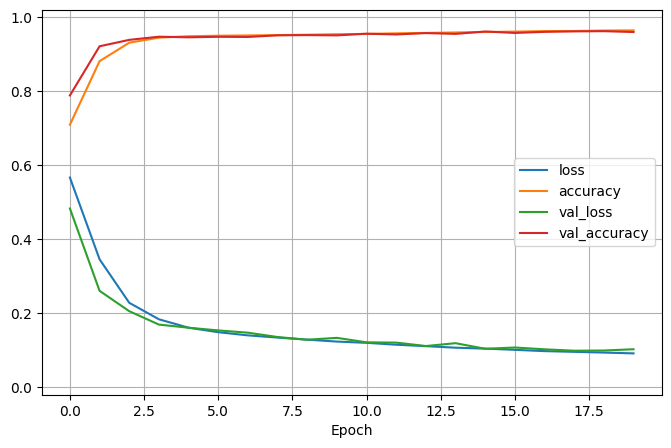

In [ ]:
pd.DataFrame(history_fl_1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(-0.02, 1.02)
plt.xlabel('Epoch')
plt.show()

Djúpt tauganet með 4 földum lögum - flokkun

In [ ]:
flokkun_2 = keras.models.Sequential()
flokkun_2.add(keras.layers.Dense(64, activation="relu"))
flokkun_2.add(keras.layers.Dense(64, activation="relu"))
flokkun_2.add(keras.layers.Dense(64, activation="relu"))
flokkun_2.add(keras.layers.Dense(64, activation="relu"))
flokkun_2.add(keras.layers.Dense(1, activation="sigmoid"))

In [ ]:
flokkun_2.build((None,8))

In [ ]:
flokkun_2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 64)                576       
                                                                 
 dense_31 (Dense)            (None, 64)                4160      
                                                                 
 dense_32 (Dense)            (None, 64)                4160      
                                                                 
 dense_33 (Dense)            (None, 64)                4160      
                                                                 
 dense_34 (Dense)            (None, 1)                 65        
                                                                 
Total params: 13121 (51.25 KB)
Trainable params: 13121 (51.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
flokkun_2.layers

In [ ]:
flokkun_2.compile(loss="binary_crossentropy",
              optimizer='adam',
              metrics=["accuracy"])

In [ ]:
history_fl_2 = flokkun_2.fit(inn_tr_skalad, sigur_tr, epochs=50,
                    validation_data=(inn_val_skalad, sigur_val))

Epoch 1/50
2500/2500 [==============================] - 11s 4ms/step - loss: 0.4038 - accuracy: 0.8159 - val_loss: 0.1893 - val_accuracy: 0.9431
Epoch 2/50
2500/2500 [==============================] - 11s 4ms/step - loss: 0.1689 - accuracy: 0.9445 - val_loss: 0.1655 - val_accuracy: 0.9460
Epoch 3/50
2500/2500 [==============================] - 9s 3ms/step - loss: 0.1475 - accuracy: 0.9485 - val_loss: 0.1386 - val_accuracy: 0.9487
Epoch 4/50
2500/2500 [==============================] - 10s 4ms/step - loss: 0.1357 - accuracy: 0.9493 - val_loss: 0.1326 - val_accuracy: 0.9492
Epoch 5/50
2500/2500 [==============================] - 10s 4ms/step - loss: 0.1243 - accuracy: 0.9528 - val_loss: 0.1178 - val_accuracy: 0.9553
Epoch 6/50
2500/2500 [==============================] - 10s 4ms/step - loss: 0.1147 - accuracy: 0.9552 - val_loss: 0.1090 - val_accuracy: 0.9571
Epoch 7/50
2500/2500 [==============================] - 9s 4ms/step - loss: 0.1054 - accuracy: 0.9590 - val_loss: 0.1070 - val_accu

In [ ]:
history_fl_2.params

{'verbose': 1, 'epochs': 50, 'steps': 2500}

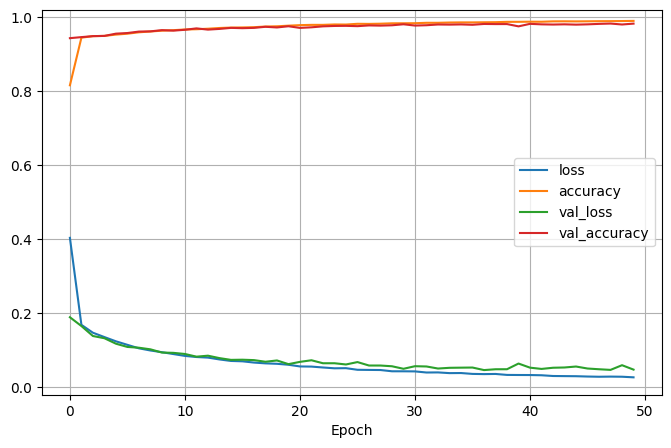

In [ ]:
pd.DataFrame(history_fl_2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(-0.02, 1.02)
plt.xlabel('Epoch')
plt.show()

Djúpt tauganet með 3 földum lögum - aðhvarfsgreining

In [ ]:
reg_1 = keras.models.Sequential()
reg_1.add(keras.layers.Dense(40, activation="relu"))
reg_1.add(keras.layers.Dense(40, activation="relu"))
reg_1.add(keras.layers.Dense(40, activation="relu"))
reg_1.add(keras.layers.Dense(1, activation="linear"))

In [ ]:
reg_1.build((None,8))

In [ ]:
reg_1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 40)                360       
                                                                 
 dense_12 (Dense)            (None, 40)                1640      
                                                                 
 dense_13 (Dense)            (None, 40)                1640      
                                                                 
 dense_14 (Dense)            (None, 1)                 41        
                                                                 
Total params: 3681 (14.38 KB)
Trainable params: 3681 (14.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
reg_1.layers

In [ ]:
reg_1.compile(loss="mse", optimizer='adam', metrics=[keras.metrics.R2Score()])

In [ ]:
history_r_1 = reg_1.fit(inn_w_tr_skalad, eink_w_tr, epochs=20,
                    validation_data=(inn_w_val_skalad, eink_w_val))

Epoch 1/20
1640/1640 [==============================] - 11s 4ms/step - loss: 60.8047 - r2_score: -0.0265 - val_loss: 42.2450 - val_r2_score: 0.2984
Epoch 2/20
1640/1640 [==============================] - 8s 5ms/step - loss: 39.9960 - r2_score: 0.3248 - val_loss: 39.0815 - val_r2_score: 0.3509
Epoch 3/20
1640/1640 [==============================] - 7s 4ms/step - loss: 38.2854 - r2_score: 0.3536 - val_loss: 37.3921 - val_r2_score: 0.3790
Epoch 4/20
1640/1640 [==============================] - 7s 4ms/step - loss: 37.3102 - r2_score: 0.3701 - val_loss: 37.0120 - val_r2_score: 0.3853
Epoch 5/20
1640/1640 [==============================] - 7s 4ms/step - loss: 36.5560 - r2_score: 0.3828 - val_loss: 36.2609 - val_r2_score: 0.3978
Epoch 6/20
1640/1640 [==============================] - 7s 4ms/step - loss: 36.0788 - r2_score: 0.3909 - val_loss: 35.8317 - val_r2_score: 0.4049
Epoch 7/20
1640/1640 [==============================] - 6s 4ms/step - loss: 35.7337 - r2_score: 0.3967 - val_loss: 35.3071

In [ ]:
history_r_1.params

{'verbose': 1, 'epochs': 20, 'steps': 1640}

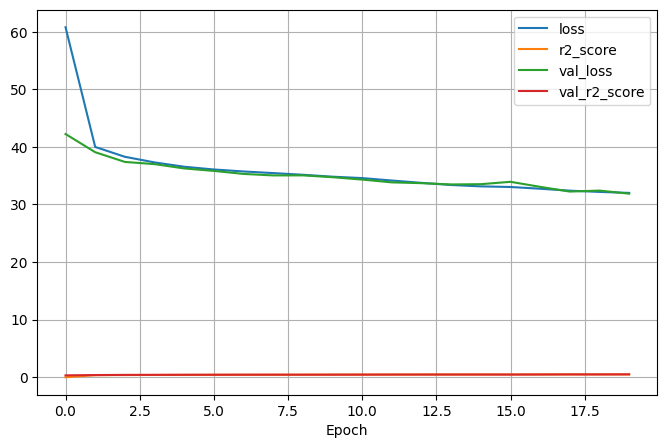

In [ ]:
pd.DataFrame(history_r_1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel('Epoch')
plt.show()

Tauganet með 1 földu lagi - aðhvarfsgreining

In [ ]:
reg_2 = keras.models.Sequential()
reg_2.add(keras.layers.Dense(100, activation="relu"))
reg_2.add(keras.layers.Dense(1, activation="linear"))

In [ ]:
reg_2.build((None,8))

In [ ]:
reg_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 100)               900       
                                                                 
 dense_16 (Dense)            (None, 1)                 101       
                                                                 
Total params: 1001 (3.91 KB)
Trainable params: 1001 (3.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
reg_2.layers

In [ ]:
reg_2.compile(loss="mse", optimizer='adam', metrics=[keras.metrics.R2Score()])

In [ ]:
history_r_2 = reg_2.fit(inn_w_tr_skalad, eink_w_tr, epochs=30,
                    validation_data=(inn_w_val_skalad, eink_w_val))

Epoch 1/30
1640/1640 [==============================] - 7s 4ms/step - loss: 87.2427 - r2_score: -0.4729 - val_loss: 47.7279 - val_r2_score: 0.2073
Epoch 2/30
1640/1640 [==============================] - 5s 3ms/step - loss: 41.9329 - r2_score: 0.2921 - val_loss: 39.2909 - val_r2_score: 0.3474
Epoch 3/30
1640/1640 [==============================] - 6s 4ms/step - loss: 38.6505 - r2_score: 0.3475 - val_loss: 38.1972 - val_r2_score: 0.3656
Epoch 4/30
1640/1640 [==============================] - 6s 4ms/step - loss: 37.8939 - r2_score: 0.3603 - val_loss: 37.6231 - val_r2_score: 0.3751
Epoch 5/30
1640/1640 [==============================] - 6s 4ms/step - loss: 37.3561 - r2_score: 0.3693 - val_loss: 37.2552 - val_r2_score: 0.3813
Epoch 6/30
1640/1640 [==============================] - 6s 4ms/step - loss: 36.9206 - r2_score: 0.3767 - val_loss: 36.8185 - val_r2_score: 0.3885
Epoch 7/30
1640/1640 [==============================] - 5s 3ms/step - loss: 36.5660 - r2_score: 0.3827 - val_loss: 36.6776 

In [ ]:
history_r_2.params

{'verbose': 1, 'epochs': 30, 'steps': 1640}

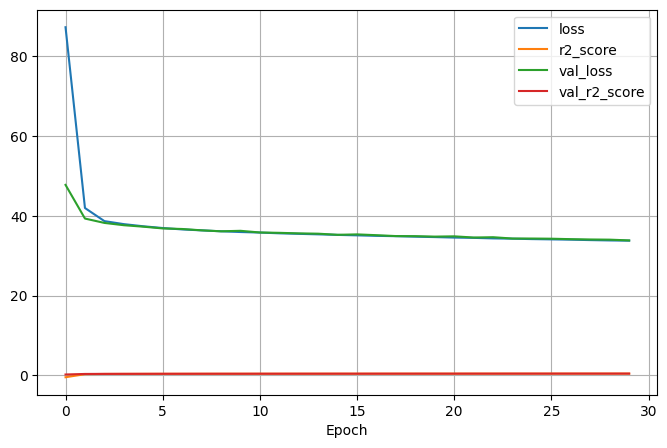

In [ ]:
pd.DataFrame(history_r_2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel('Epoch')
plt.show()

Djúpt tauganet með 2 földum lögum - aðhvarfsgreining

In [ ]:
reg_3 = keras.models.Sequential()
reg_3.add(keras.layers.Dense(64, activation="relu"))
reg_3.add(keras.layers.Dense(64, activation="relu"))
reg_3.add(keras.layers.Dense(1, activation="linear"))

In [ ]:
reg_3.build((None,8))

In [ ]:
reg_3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 64)                576       
                                                                 
 dense_18 (Dense)            (None, 64)                4160      
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4801 (18.75 KB)
Trainable params: 4801 (18.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
reg_3.layers

In [ ]:
reg_3.compile(loss="mse", optimizer='adam', metrics=[keras.metrics.R2Score()])

In [ ]:
history_r_3 = reg_3.fit(inn_w_tr_skalad, eink_w_tr, epochs=20,
                    validation_data=(inn_w_val_skalad, eink_w_val))

Epoch 1/20
1640/1640 [==============================] - 7s 4ms/step - loss: 63.0490 - r2_score: -0.0644 - val_loss: 48.3890 - val_r2_score: 0.1963
Epoch 2/20
1640/1640 [==============================] - 7s 4ms/step - loss: 46.0165 - r2_score: 0.2231 - val_loss: 41.6495 - val_r2_score: 0.3083
Epoch 3/20
1640/1640 [==============================] - 6s 4ms/step - loss: 39.8899 - r2_score: 0.3266 - val_loss: 38.9668 - val_r2_score: 0.3528
Epoch 4/20
1640/1640 [==============================] - 7s 4ms/step - loss: 38.5304 - r2_score: 0.3495 - val_loss: 37.9509 - val_r2_score: 0.3697
Epoch 5/20
1640/1640 [==============================] - 6s 4ms/step - loss: 37.7798 - r2_score: 0.3622 - val_loss: 37.4984 - val_r2_score: 0.3772
Epoch 6/20
1640/1640 [==============================] - 7s 4ms/step - loss: 37.0134 - r2_score: 0.3751 - val_loss: 36.8510 - val_r2_score: 0.3880
Epoch 7/20
1640/1640 [==============================] - 6s 4ms/step - loss: 36.2291 - r2_score: 0.3884 - val_loss: 36.2554 

In [ ]:
history_r_3.params

{'verbose': 1, 'epochs': 20, 'steps': 1640}

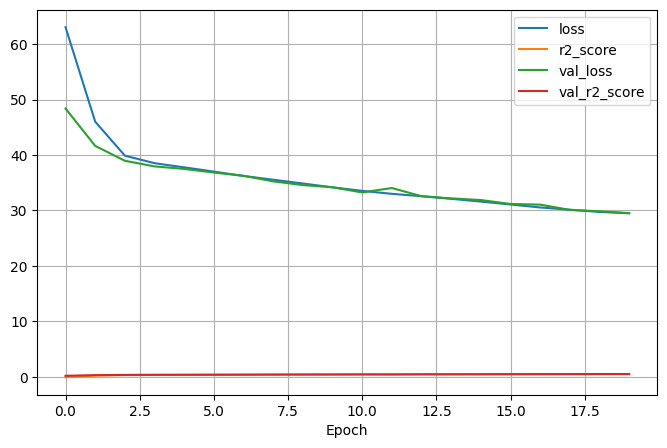

In [ ]:
pd.DataFrame(history_r_3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel('Epoch')
plt.show()

Djúpt tauganet með 4 földum lögum - aðhvarfsgreining

In [16]:
reg_4 = keras.models.Sequential()
reg_4.add(keras.layers.Dense(64, activation="relu"))
reg_4.add(keras.layers.Dense(64, activation="relu"))
reg_4.add(keras.layers.Dense(64, activation="relu"))
reg_4.add(keras.layers.Dense(64, activation="relu"))
reg_4.add(keras.layers.Dense(1, activation="linear"))

In [17]:
reg_4.build((None,8))

In [18]:
reg_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                576       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 13121 (51.25 KB)
Trainable params: 13121 (51.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
reg_4.layers

In [20]:
reg_4.compile(loss="mse", optimizer='adam', metrics=[keras.metrics.R2Score()])

In [21]:
history_r_4 = reg_4.fit(inn_w_tr_skalad, eink_w_tr, epochs=100,
                    validation_data=(inn_w_val_skalad, eink_w_val))

Epoch 1/100
1640/1640 [==============================] - 11s 4ms/step - loss: 48.1918 - r2_score: 0.1864 - val_loss: 36.7649 - val_r2_score: 0.3894
Epoch 2/100
1640/1640 [==============================] - 7s 4ms/step - loss: 36.2520 - r2_score: 0.3880 - val_loss: 35.7153 - val_r2_score: 0.4068
Epoch 3/100
1640/1640 [==============================] - 7s 5ms/step - loss: 35.2248 - r2_score: 0.4053 - val_loss: 34.5282 - val_r2_score: 0.4265
Epoch 4/100
1640/1640 [==============================] - 7s 4ms/step - loss: 34.5492 - r2_score: 0.4167 - val_loss: 34.1106 - val_r2_score: 0.4335
Epoch 5/100
1640/1640 [==============================] - 8s 5ms/step - loss: 34.0506 - r2_score: 0.4251 - val_loss: 33.7042 - val_r2_score: 0.4402
Epoch 6/100
1640/1640 [==============================] - 7s 4ms/step - loss: 33.7212 - r2_score: 0.4307 - val_loss: 35.2565 - val_r2_score: 0.4145
Epoch 7/100
1640/1640 [==============================] - 7s 4ms/step - loss: 33.3404 - r2_score: 0.4371 - val_loss: 3

In [22]:
history_r_4.params

{'verbose': 1, 'epochs': 100, 'steps': 1640}

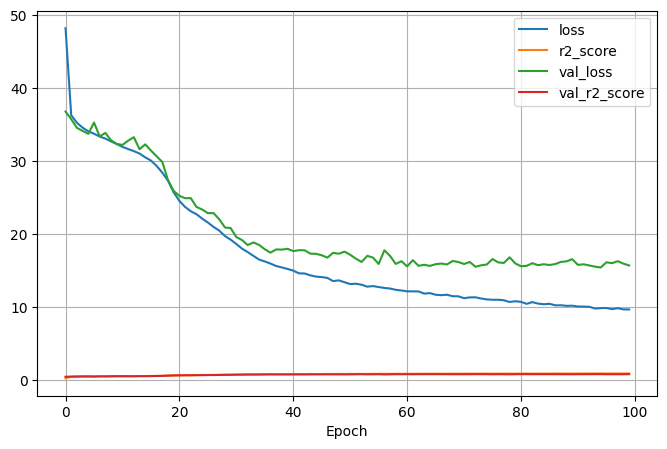

In [23]:
pd.DataFrame(history_r_4.history).plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel('Epoch')
plt.show()

Set innmerkin inn í tauganetið sem ég var að þjálfa og skoða hvað kemur út úr því.

In [24]:
eink_w_tr_pred = reg_4.predict(inn_w_tr_skalad)
eink_w_val_pred = reg_4.predict(inn_w_val_skalad)

410/410 [==============================] - 1s 2ms/step


Rétt gildi vs. gildi sem kemur úr tauganeti - þjálfunargögn

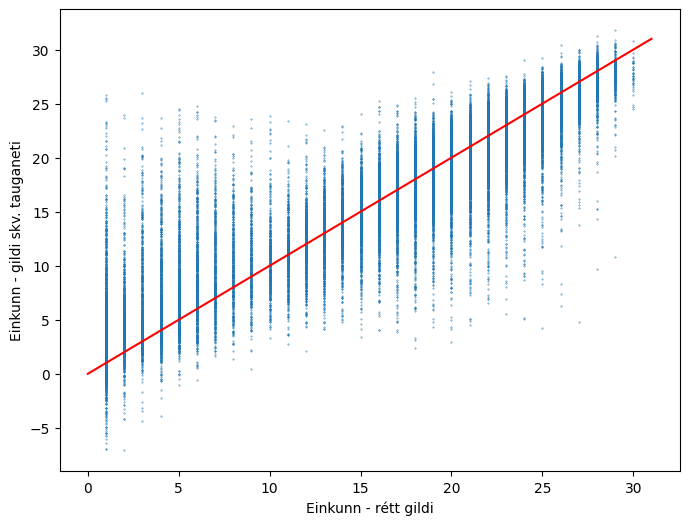

In [42]:
plt.figure(figsize=(8, 6))
plt.scatter(eink_w_tr, eink_w_tr_pred, s=0.1)
plt.plot([0, 31], [0, 31], 'r')
plt.ylabel('Einkunn - gildi skv. tauganeti')
plt.xlabel('Einkunn - rétt gildi')
plt.show()

Rétt gildi vs. gildi sem kemur úr tauganeti - validation gögn

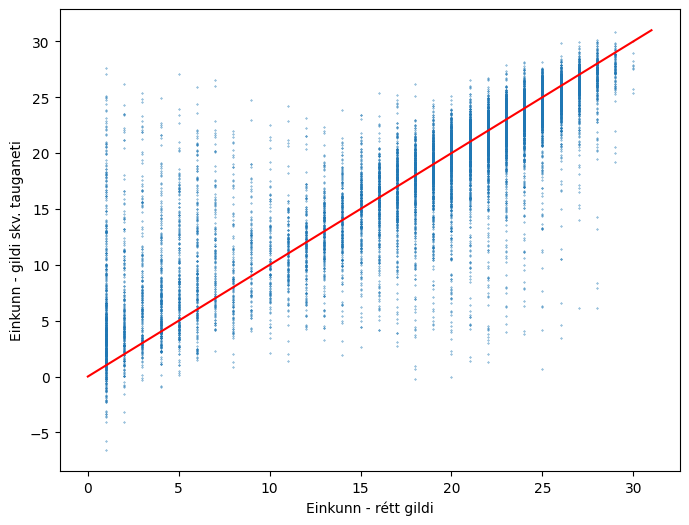

In [43]:
plt.figure(figsize=(8, 6))
plt.scatter(eink_w_val, eink_w_val_pred, s=0.1)
plt.plot([0, 31], [0, 31], 'r')
plt.ylabel('Einkunn - gildi skv. tauganeti')
plt.xlabel('Einkunn - rétt gildi')
plt.show()